In [37]:
from models.adapters.base import BaseAdapter
from models.selector import FilterSelector
from models.quantization import conv2d_outter, conv2d_core
from experiments.planner import CGPPinPlanner
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import pandas as pd
import numpy as np

# Disable LaTeX rendering
plt.rc('text', usetex=False)

data_store = Path("../../data_store/channel_lenet")
data_store.mkdir(exist_ok=True, parents=True)
loaded = False
sns.set_palette("deep")
sns.color_palette("deep")

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [39]:
adapter = BaseAdapter.load_base_model("qat_quantized_lenet", "./trained_models/qat.quantized_lenet.pth")

c:\Users\Majo\.conda\envs\masters\Lib\site-packages\torch\ao\quantization\observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\torch\ao\quantization\observer.py:1207: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\torch\_utils.py:376: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,


In [41]:
assert isinstance(adapter, BaseAdapter)
data = []
# while not data or data[-1][2][1] >= 0.75:
for e in range(-70, 70, 1):
    adapter = BaseAdapter.load_base_model("qat_quantized_lenet", "./trained_models/qat.quantized_lenet.pth")
    # layers = [adapter.get_layer(layer) for layer in ["conv1"]]
    for layer in ["conv1"]:
        weights, bias = adapter.get_train_weights(layer), adapter.get_bias(layer)
        planner = CGPPinPlanner()
        
        for filter_i, filter_weights in enumerate(weights):
            for channel_i, channel_filters in enumerate(filter_weights):
                for selector in conv2d_core([filter_i, channel_i], 5, 3):
                    weights[*selector] = weights[*selector] + e
        
        adapter.inject_weights([weights.flatten()], [[FilterSelector(layer, [], [[slice(None), slice(None), slice(None), slice(None)]])]])
    top_k, avg_loss = adapter.evaluate(top=[1, 5])
    data.append([e] + list(top_k.items()) + [avg_loss])
    
loaded = True
    

c:\Users\Majo\.conda\envs\masters\Lib\site-packages\torch\ao\quantization\observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\torch\ao\quantization\observer.py:1207: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(


In [3]:
df_files = ["lenet.256.csv", "lenet.outter.256.csv", "lenet.inner.256.csv"]

if not loaded:
    df_loaded_files = []
    for file in df_files:
        df_temp = pd.read_csv(data_store / file)
        df_temp["type"] = "outter" if "outter" in file else "inner" if "inner" in file else "all"
        df_loaded_files.append(df_temp)
    df = pd.concat(df_loaded_files)
    df.columns = [col.title() for col in df.columns]
    df["Type"] = df["Type"].str.title()
else:
    new_data = []
    for row in data:
        new_row = [row[0]]
        for k, x in row[1:-1]:
            new_row.append(x)
        new_row.append(row[-1])
        new_data.append(tuple(new_row))

    df = pd.DataFrame(data=new_data, columns=["error", "top-1", "top-5", "loss"])
    df.to_csv(data_store / "lenet.inner.256.csv", index=False)

c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite v

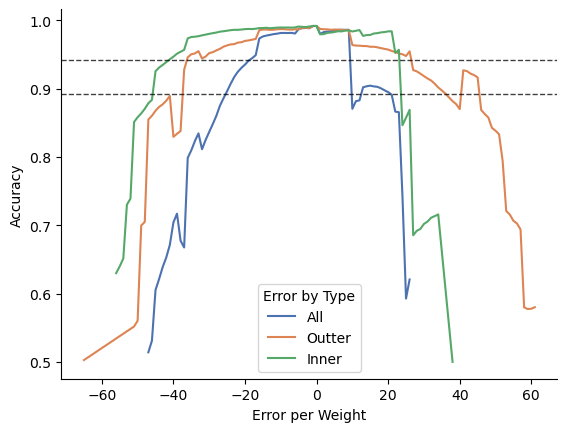

In [15]:
def get_x(y_value: int, point_a, point_b):
    x1, y1 = point_a
    x2, y2 = point_b
    x_hat = None
    if y1 <= y_value <= y2 and y2 <= y_value <= y1:
        m = (y2-y1) / (x2-x1)
        b = y1 - m * x1
        x_hat = (y_value - b) / m
    
    return x_hat
        

def plot_line(g, value, label):
    x_min = float("inf")
    x_max = float("-inf")
    ax = g.axes
    # for ax in g.axes.flat:
    #     ax = ax
    for line in g.axes.lines:
        # for line in ax.lines:
        x, y = line.get_data()
        if isinstance(x, list) or x.size == 0 or y.size == 0: continue
        
        for a, b in zip(zip(x[0:-2], y[0:-2]), zip(x[1:], y[1:])):
            x_hat = get_x(value, a, b)
            
            if x_hat is None:
                continue
            
            x_min = min([x_min, x_hat])
            x_max = max([x_max, x_hat])                    
            
    ax.text(x_min, value, f" {x_min:.1f} ({label})", ha="left", va="top", alpha=0.6)
    ax.text(x_max, value, f" {x_max:.1f} ({label})", ha="left", va="top", alpha=0.6)
    ax.axhline(value, linestyle="--", color="black", linewidth=1, alpha=0.75)    
    # ax.axvline(x_min, linestyle="--", color="green", linewidth=1, alpha=0.75)    
    # ax.axvline(x_max, linestyle="--", color="green", linewidth=1, alpha=0.75)
    ax.scatter(x_min, value, color="black", alpha=0.75, marker="x", linewidth=1)
    ax.scatter(x_max, value, color="black", alpha=0.75, marker="x", linewidth=1)
    # ax.(x_max, linestyle="--", color="green", linewidth=1, alpha=0.75)    
        # ax.axhline(value, linestyle="--", color="#cfcfcf", lw=2, alpha=0.75)    

filtered_df = df.loc[df["Top-1"] > 0.5, :]
value_vars = ["Top-1"]
y = "Accuracy"
target = filtered_df.loc[filtered_df["Error"] == 0, "Top-1"].max()

plot_df = pd.melt(filtered_df, id_vars=["Error", "Type"], value_vars=value_vars, var_name="Metric", value_name="Accuracy")

fig, (ax1) = plt.subplots()
g1 = sns.lineplot(data=plot_df, x="Error", y=y, hue="Type", markers=True, ax=ax1)
g1.set(xlabel="Error per Weight")
plt.legend(title="Error by Type")
# g1.xaxis.set_major_locator(MultipleLocator(5))
plot_line(g1, target * 0.95, "α = 0.05")
plot_line(g1, target * 0.90, "α = 0.10")

sns.despine(fig)

# ax1.get_legend().remove()

# plot_line(ax, 0.90286, "MobileNetV2 top-5")
# plt.xlim(plot_df["error"].min(), plot_df["error"].max())
plt.savefig(data_store / "lenet_channel.256.error.svg")
plt.savefig(data_store / "lenet_channel.256.error.png")
plt.savefig(data_store / "lenet_channel.256.error.pdf")


In [36]:
a_df = filtered_df.loc[(filtered_df["Type"] == "Outter") & (filtered_df["Top-1"] >= 0.95), :]
b_df = filtered_df.loc[(filtered_df["Type"] == "Outter") & (filtered_df["Top-1"] >= 0.9) & (filtered_df["Top-1"] < 0.95), :]
c_df = filtered_df.loc[(filtered_df["Type"] == "Outter") & (filtered_df["Top-1"] >= 0.8) & (filtered_df["Top-1"] < 0.9), :]
d_df = filtered_df.loc[(filtered_df["Type"] == "Outter") & (filtered_df["Top-1"] >= 0.7) & (filtered_df["Top-1"] < 0.8), :]

a_df["Error backup"] = a_df["Error"]
b_df["Error backup"] = b_df["Error"]
c_df["Error backup"] = c_df["Error"]
d_df["Error backup"] = c_df["Error"]

a_min_idx = a_df["Error"].apply(lambda x: abs(x)).idxmax()
b_min_idx = b_df["Error"].apply(lambda x: abs(x)).idxmax()
c_min_idx = c_df["Error"].apply(lambda x: abs(x)).idxmax()
d_min_idx = d_df["Error"].apply(lambda x: abs(x)).idxmax()

a_min_row = a_df.loc[a_min_idx]
b_min_row = b_df.loc[b_min_idx]
c_min_row = c_df.loc[c_min_idx]
d_min_row = d_df.loc[d_min_idx]

print(a_min_row, b_min_row, c_min_row, d_min_row)


Error              -35
Top-1           0.9503
Top-5           0.9989
Loss            0.2087
Type            Outter
Error backup       -35
Name: 35, dtype: object Error                 45
Top-1             0.9164
Top-5             0.9972
Loss            0.414997
Type              Outter
Error backup          45
Name: 115, dtype: object Error                 51
Top-1             0.8332
Top-5             0.9907
Loss            0.699408
Type              Outter
Error backup          51
Name: 121, dtype: object Error                 56
Top-1             0.7027
Top-5             0.9764
Loss            1.231128
Type              Outter
Error backup         NaN
Name: 126, dtype: object


C:\Users\Majo\AppData\Local\Temp\ipykernel_34352\1736112342.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a_df["Error backup"] = a_df["Error"]
C:\Users\Majo\AppData\Local\Temp\ipykernel_34352\1736112342.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b_df["Error backup"] = b_df["Error"]
C:\Users\Majo\AppData\Local\Temp\ipykernel_34352\1736112342.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead
